In [9]:
import cv2
import tensorflow as tf
from glob import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split

In [15]:
# PATH = "drive/MyDrive/Breast-Ultrasound-Images/Dataset_BUSI_with_GT"
PATH = "/Users/umpi/Documents/ResearchData/Dataset_BUSI_with_GT"
tpu_ = False

In [11]:
if tpu_:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [12]:
def collect_data(name):
    """
    For a classname create the two path list of images and masks
    """
    all_images = sorted(
        glob(os.path.join(PATH, name + "/*).png")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    all_masks = sorted(
        glob(os.path.join(PATH, name + "/*mask*")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    # print(all_masks[:4])
    return all_images, all_masks


def group_maks(masks):
    """
    Read the mask file and combine the masks images when their are several masks for a
    single image ( after
    """
    new_masks = []
    retard = 0
    for i in range(len(masks)):
        m = re.search(r"mask_[0-9]", masks[i]) # we are looking for masks that correspond to the same inputs
        if m:
            new_masks[i - (retard + 1)] += cv2.resize(
                cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
            )
            retard += 1
        else:
            new_masks.append(
                cv2.resize(
                    cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
                )  # resize needed because the image need to have the same size
            )

    return new_masks


def load_dataset():
    """
    Combine the previous function and differents class label and apply train_test_split on it

    Retuns :
        - X_train() : the matrix of training images
        - y_train() : the matrix of training masks
        - X_test() : the matrix of testing images
        - y_test() : the matrix of testing masks
    """
    all_benign_images, all_benign_masks = collect_data("benign")

    # Here all = tf.constant(all_benign_masks) works
    all_benign_masks = group_maks(all_benign_masks)
    # Here it doesnt
    all_malignant_images, all_malignant_masks = collect_data("malignant")
    all_malignant_masks = group_maks(all_malignant_masks)

    all_images = all_benign_images + all_malignant_images
    all_masks = all_benign_masks + all_malignant_masks

    X_train, X_test = train_test_split(
        all_images,
        test_size=0.2,
        random_state=1,
        # shuffle=True,
    )
    y_train, y_test = train_test_split(
        all_masks,
        test_size=0.2,
        random_state=1,
        # shuffle=True,
    )
    return (X_train, y_train), (X_test, y_test)


def show_some_images(images, masks):
    """
    Show a numbers of images and it's associated masks
    """

    random_number = randint(0, len(images) - 6)
    # random_number = 4  # Used to check on malignant
    plt.figure(figsize=(20, 10))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[random_number + i + 1], "gray")
        plt.axis("off")
        plt.title("Real Image")
    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.imshow(masks[random_number + i + 1], "gray")
        plt.title("Mask Image")
        plt.axis("off")
    plt.show()


def process_image(image, HEIGHT=256, WIDTH=256):
    image = image.decode("utf-8")
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = image / 255.0

    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    return image


def process_mask(mask):
    """
    Mask proccessing function
    """
    mask = mask.astype(np.float32)
    mask = mask / 255
    mask = np.round(mask) # Rounds between 0 and 1 each pixels
    mask = np.expand_dims(mask, axis=-1)  # need shape to be (256,256,1)
    return mask


def preprocess(x, y):
    def f(x, y):
        image = process_image(x)
        mask = process_mask(y)
        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([256, 256, 1])
    mask.set_shape([256, 256, 1])
    return image, mask


def tf_dataset(x, y, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(preprocess)
    ds = ds.batch(batch_size)
    return ds


def load(batch_size=16):
    (X_train, y_train), (X_test, y_test) = load_dataset()
    """ X_train = X_train[:64]
    y_train = y_train[:64]
    X_test = X_test[:64]
    y_test = y_test[:64] """
    train_ds = tf_dataset(X_train, y_train, batch_size=batch_size)
    test_ds = tf_dataset(X_test, y_test, batch_size=batch_size)
    return train_ds, test_ds

2022-09-06 11:41:06.128328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-06 11:41:06.128491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2022-09-06 11:41:09.022888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


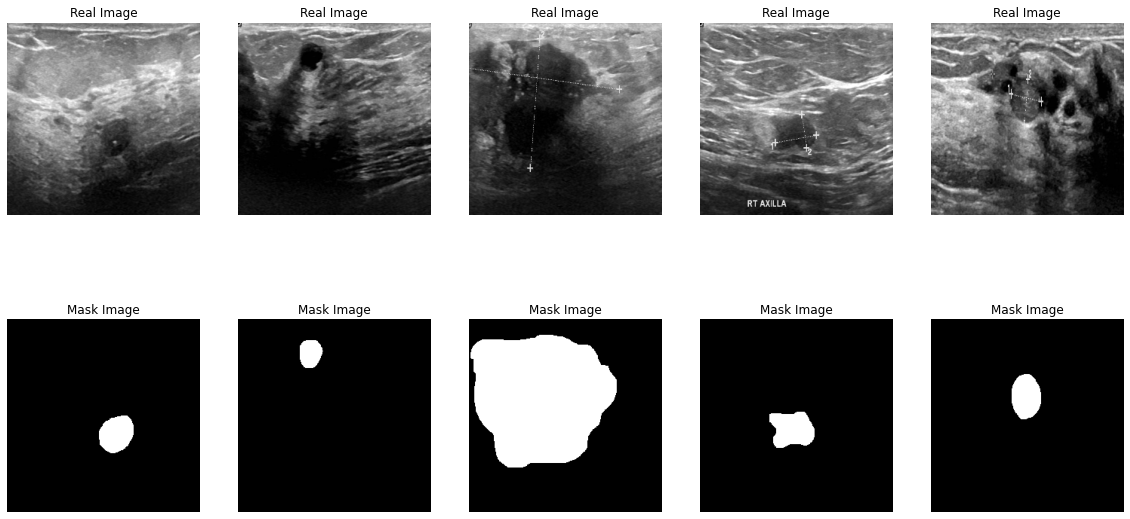

In [16]:
(X_train, y_train), (X_test, y_test) = load_dataset()
train_ds = tf_dataset(X_train, y_train, batch_size=16)
test_ds = tf_dataset(X_test, y_test, batch_size=16)
for x, y in train_ds.take(1):
    show_some_images(x, y)

In [17]:

def block_conv_down(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    p = tf.keras.layers.Dropout(0.2)(p)
    return x, p


def bottleneck(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def block_conv_up(x, p, dims):
    p = tf.keras.layers.UpSampling2D(2)(p)
    u = tf.keras.layers.Concatenate(axis=-1)([p, x])

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    return u


def UNET(input_shape):
    input = tf.keras.layers.Input(shape=input_shape)
    x1, p1 = block_conv_down(input, 64)
    # print(f" x1 shape : {x1.shape}")
    x2, p2 = block_conv_down(p1, 128)
    # print(f" x2 shape : {x2.shape}")
    x3, p3 = block_conv_down(p2, 256)
    # print(f" x3 shape : {x3.shape}")
    x4, p4 = block_conv_down(p3, 512)
    # print(f" x4 shape : {x4.shape}")

    p5 = bottleneck(p4, 1024)
    # print(f" p5 shape : {p5.shape}")
    p6 = block_conv_up(x4, p5, 512)
    # print(f" p6 shape : {p6.shape}")
    p7 = block_conv_up(x3, p6, 256)
    # print(f" p7 shape : {p7.shape}")
    p8 = block_conv_up(x2, p7, 128)
    # print(f" p8 shape : {p8.shape}")
    p9 = block_conv_up(x1, p8, 64)

    # print(f" p9 shape : {p9.shape}")

    output = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(p9)
    # output = tf.keras.layers.Conv2D(2,(1,1), activation = "softmax")
    model = tf.keras.Model(inputs=input, outputs=output)

    return model

In [18]:
if tpu_:
    with tpu_strategy.scope():
        model = UNET((256, 256, 1))
        
        model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
        model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=50,
            steps_per_epoch=len(train_ds),
            )
else :
    model = UNET((256, 256, 1))
        
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=50,
            steps_per_epoch=len(train_ds),
            )

Epoch 1/50


2022-09-06 11:42:19.575906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8588

2022-09-06 11:43:18.939536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 64s 2s/step - loss: 0.4062 - accuracy: 0.8588 - val_loss: 248390.4062 - val_accuracy: 0.0977
Epoch 2/50
33/33 [==============================] - 57s 2s/step - loss: 0.2906 - accuracy: 0.9120 - val_loss: 89.0312 - val_accuracy: 0.1726
Epoch 3/50
33/33 [==============================] - 57s 2s/step - loss: 0.2752 - accuracy: 0.9120 - val_loss: 142.2200 - val_accuracy: 0.1003
Epoch 4/50
33/33 [==============================] - 57s 2s/step - loss: 0.2531 - accuracy: 0.9176 - val_loss: 92.2989 - val_accuracy: 0.1008
Epoch 5/50
33/33 [==============================] - 57s 2s/step - loss: 0.2176 - accuracy: 0.9254 - val_loss: 36.0271 - val_accuracy: 0.1563
Epoch 6/50
33/33 [==============================] - 59s 2s/step - loss: 0.2057 - accuracy: 0.9291 - val_loss: 15.7444 - val_accuracy: 0.1919
Epoch 7/50
33/33 [==============================] - 59s 2s/step - loss: 0.1986 - accuracy: 0.9303 - val_loss: 1.0910 - val_accuracy: 0.6381
Epoch 8/50
33/33 [==

In [19]:
model.save("UNETBreast.h5")